In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [ ]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128_exp", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_CIFAR10-DVS_Hardtanh_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kerne

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=87,save_best=True, save_thr=90)

100%|██████████| 219/219 [01:11<00:00,  3.05it/s]


Epoch [1/87], Step [219/219], Loss: 3.2058, Accuracy: 0.1009
Accuracy of the network: 0.10066666666666667 Loss: 2.8596000011931073


100%|██████████| 219/219 [01:06<00:00,  3.28it/s]


Epoch [2/87], Step [219/219], Loss: 2.6976, Accuracy: 0.0996
Accuracy of the network: 0.09066666666666667 Loss: 2.5886535111894


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [3/87], Step [219/219], Loss: 2.6127, Accuracy: 0.1131
Accuracy of the network: 0.094 Loss: 2.575305570947363


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [4/87], Step [219/219], Loss: 2.3785, Accuracy: 0.1094
Accuracy of the network: 0.099 Loss: 2.343025582901975


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [5/87], Step [219/219], Loss: 2.2434, Accuracy: 0.1506
Accuracy of the network: 0.16233333333333333 Loss: 2.140568239891783


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [6/87], Step [219/219], Loss: 2.1725, Accuracy: 0.1576
Accuracy of the network: 0.15733333333333333 Loss: 2.1485890048615475


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [7/87], Step [219/219], Loss: 2.1378, Accuracy: 0.1747
Accuracy of the network: 0.16333333333333333 Loss: 2.097321884429201


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [8/87], Step [219/219], Loss: 2.1073, Accuracy: 0.1749
Accuracy of the network: 0.18266666666666667 Loss: 2.087189422008839


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [9/87], Step [219/219], Loss: 2.1077, Accuracy: 0.1796
Accuracy of the network: 0.19066666666666668 Loss: 2.091540367045301


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [10/87], Step [219/219], Loss: 2.1000, Accuracy: 0.1861
Accuracy of the network: 0.19833333333333333 Loss: 2.082450491316775


100%|██████████| 219/219 [01:09<00:00,  3.16it/s]


Epoch [11/87], Step [219/219], Loss: 2.0895, Accuracy: 0.1746
Accuracy of the network: 0.182 Loss: 2.088462896803592


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [12/87], Step [219/219], Loss: 2.0934, Accuracy: 0.1896
Accuracy of the network: 0.19 Loss: 2.0812921042137957


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [13/87], Step [219/219], Loss: 2.0736, Accuracy: 0.1949
Accuracy of the network: 0.20533333333333334 Loss: 2.079410490837503


100%|██████████| 219/219 [01:13<00:00,  2.99it/s]


Epoch [14/87], Step [219/219], Loss: 2.0719, Accuracy: 0.2003
Accuracy of the network: 0.186 Loss: 2.068669121316139


100%|██████████| 219/219 [01:09<00:00,  3.17it/s]


Epoch [15/87], Step [219/219], Loss: 2.0735, Accuracy: 0.1966
Accuracy of the network: 0.20033333333333334 Loss: 2.074333925196465


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [16/87], Step [219/219], Loss: 2.0662, Accuracy: 0.1994
Accuracy of the network: 0.19533333333333333 Loss: 2.0807153227481434


100%|██████████| 219/219 [01:09<00:00,  3.17it/s]


Epoch [17/87], Step [219/219], Loss: 2.0609, Accuracy: 0.2070
Accuracy of the network: 0.18166666666666667 Loss: 2.0552760869898696


100%|██████████| 219/219 [01:10<00:00,  3.12it/s]


Epoch [18/87], Step [219/219], Loss: 2.0526, Accuracy: 0.2047
Accuracy of the network: 0.21 Loss: 2.065827080544005


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [19/87], Step [219/219], Loss: 2.0515, Accuracy: 0.2066
Accuracy of the network: 0.187 Loss: 2.0732560069003005


100%|██████████| 219/219 [01:08<00:00,  3.20it/s]


Epoch [20/87], Step [219/219], Loss: 2.0344, Accuracy: 0.2133
Accuracy of the network: 0.22533333333333333 Loss: 2.0263470893210553


100%|██████████| 219/219 [01:09<00:00,  3.14it/s]


Epoch [21/87], Step [219/219], Loss: 1.9616, Accuracy: 0.2574
Accuracy of the network: 0.255 Loss: 1.9436319571860292


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [22/87], Step [219/219], Loss: 1.9048, Accuracy: 0.2820
Accuracy of the network: 0.2783333333333333 Loss: 1.90966057523768


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [23/87], Step [219/219], Loss: 1.8707, Accuracy: 0.2976
Accuracy of the network: 0.30266666666666664 Loss: 1.8811849862971204


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [24/87], Step [219/219], Loss: 1.8559, Accuracy: 0.3050
Accuracy of the network: 0.2786666666666667 Loss: 1.894781489321526


100%|██████████| 219/219 [01:00<00:00,  3.61it/s]


Epoch [25/87], Step [219/219], Loss: 1.8368, Accuracy: 0.3080
Accuracy of the network: 0.272 Loss: 1.9069578850522955


100%|██████████| 219/219 [00:49<00:00,  4.46it/s]


Epoch [26/87], Step [219/219], Loss: 1.8247, Accuracy: 0.3149
Accuracy of the network: 0.30866666666666664 Loss: 1.839854784468387


100%|██████████| 219/219 [00:49<00:00,  4.43it/s]


Epoch [27/87], Step [219/219], Loss: 1.8119, Accuracy: 0.3374
Accuracy of the network: 0.30466666666666664 Loss: 1.8468793478417904


100%|██████████| 219/219 [00:49<00:00,  4.43it/s]


Epoch [28/87], Step [219/219], Loss: 1.7863, Accuracy: 0.3379
Accuracy of the network: 0.3243333333333333 Loss: 1.8156427424004737


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [29/87], Step [219/219], Loss: 1.7646, Accuracy: 0.3423
Accuracy of the network: 0.31533333333333335 Loss: 1.8337455315792814


100%|██████████| 219/219 [00:49<00:00,  4.43it/s]


Epoch [30/87], Step [219/219], Loss: 1.7573, Accuracy: 0.3477
Accuracy of the network: 0.335 Loss: 1.805939201344835


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [31/87], Step [219/219], Loss: 1.7464, Accuracy: 0.3586
Accuracy of the network: 0.347 Loss: 1.781841865245332


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [32/87], Step [219/219], Loss: 1.7178, Accuracy: 0.3716
Accuracy of the network: 0.349 Loss: 1.7825509170268445


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [33/87], Step [219/219], Loss: 1.7030, Accuracy: 0.3717
Accuracy of the network: 0.36033333333333334 Loss: 1.742339919222162


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [34/87], Step [219/219], Loss: 1.6708, Accuracy: 0.3936
Accuracy of the network: 0.35633333333333334 Loss: 1.7292479504930212


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [35/87], Step [219/219], Loss: 1.6571, Accuracy: 0.3966
Accuracy of the network: 0.363 Loss: 1.701247901358503


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [36/87], Step [219/219], Loss: 1.6439, Accuracy: 0.3974
Accuracy of the network: 0.36966666666666664 Loss: 1.6955125775743038


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [37/87], Step [219/219], Loss: 1.6180, Accuracy: 0.4086
Accuracy of the network: 0.395 Loss: 1.6603580345498754


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [38/87], Step [219/219], Loss: 1.6014, Accuracy: 0.4199
Accuracy of the network: 0.39866666666666667 Loss: 1.6616882998892601


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [39/87], Step [219/219], Loss: 1.5867, Accuracy: 0.4200
Accuracy of the network: 0.398 Loss: 1.6414509200035257


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [40/87], Step [219/219], Loss: 1.5751, Accuracy: 0.4323
Accuracy of the network: 0.407 Loss: 1.6367202959162124


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [41/87], Step [219/219], Loss: 1.5607, Accuracy: 0.4337
Accuracy of the network: 0.414 Loss: 1.6194303086463442


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [42/87], Step [219/219], Loss: 1.5501, Accuracy: 0.4424
Accuracy of the network: 0.4236666666666667 Loss: 1.604177970835503


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [43/87], Step [219/219], Loss: 1.5344, Accuracy: 0.4494
Accuracy of the network: 0.4196666666666667 Loss: 1.6048619633025312


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [44/87], Step [219/219], Loss: 1.5184, Accuracy: 0.4521
Accuracy of the network: 0.42866666666666664 Loss: 1.5951968976791868


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [45/87], Step [219/219], Loss: 1.4947, Accuracy: 0.4560
Accuracy of the network: 0.418 Loss: 1.5968754950990067


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [46/87], Step [219/219], Loss: 1.4925, Accuracy: 0.4611
Accuracy of the network: 0.422 Loss: 1.576482448172062


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [47/87], Step [219/219], Loss: 1.4828, Accuracy: 0.4650
Accuracy of the network: 0.42766666666666664 Loss: 1.579151896720237


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [48/87], Step [219/219], Loss: 1.4598, Accuracy: 0.4747
Accuracy of the network: 0.434 Loss: 1.5751142197466912


100%|██████████| 219/219 [00:49<00:00,  4.46it/s]


Epoch [49/87], Step [219/219], Loss: 1.4608, Accuracy: 0.4739
Accuracy of the network: 0.44966666666666666 Loss: 1.5409341974461332


100%|██████████| 219/219 [00:49<00:00,  4.45it/s]


Epoch [50/87], Step [219/219], Loss: 1.4474, Accuracy: 0.4767
Accuracy of the network: 0.43933333333333335 Loss: 1.543915401113794


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [51/87], Step [219/219], Loss: 1.4356, Accuracy: 0.4884
Accuracy of the network: 0.44766666666666666 Loss: 1.533778595163467


100%|██████████| 219/219 [00:49<00:00,  4.38it/s]


Epoch [52/87], Step [219/219], Loss: 1.4300, Accuracy: 0.4869
Accuracy of the network: 0.44433333333333336 Loss: 1.5423476505786815


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [53/87], Step [219/219], Loss: 1.4203, Accuracy: 0.4867
Accuracy of the network: 0.439 Loss: 1.5386378574878612


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [54/87], Step [219/219], Loss: 1.4152, Accuracy: 0.4926
Accuracy of the network: 0.45166666666666666 Loss: 1.5339981203383588


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [55/87], Step [219/219], Loss: 1.4113, Accuracy: 0.4947
Accuracy of the network: 0.44666666666666666 Loss: 1.534822625048617


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [56/87], Step [219/219], Loss: 1.4022, Accuracy: 0.4927
Accuracy of the network: 0.44533333333333336 Loss: 1.5366173944574721


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [57/87], Step [219/219], Loss: 1.3889, Accuracy: 0.5019
Accuracy of the network: 0.4553333333333333 Loss: 1.524783561838434


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [58/87], Step [219/219], Loss: 1.3944, Accuracy: 0.5004
Accuracy of the network: 0.455 Loss: 1.5193432772413213


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [59/87], Step [219/219], Loss: 1.3921, Accuracy: 0.5029
Accuracy of the network: 0.4593333333333333 Loss: 1.5135944701255637


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [60/87], Step [219/219], Loss: 1.3727, Accuracy: 0.5061
Accuracy of the network: 0.4613333333333333 Loss: 1.5218617079105783


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [61/87], Step [219/219], Loss: 1.3756, Accuracy: 0.4976
Accuracy of the network: 0.45966666666666667 Loss: 1.5121247387946921


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [62/87], Step [219/219], Loss: 1.3728, Accuracy: 0.5066
Accuracy of the network: 0.45966666666666667 Loss: 1.5066842829927485


100%|██████████| 219/219 [00:49<00:00,  4.38it/s]


Epoch [63/87], Step [219/219], Loss: 1.3712, Accuracy: 0.5067
Accuracy of the network: 0.46 Loss: 1.5169839199553146


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [64/87], Step [219/219], Loss: 1.3777, Accuracy: 0.5083
Accuracy of the network: 0.4613333333333333 Loss: 1.5079894902858328


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [65/87], Step [219/219], Loss: 1.3766, Accuracy: 0.5030
Accuracy of the network: 0.464 Loss: 1.5079993592931868


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [66/87], Step [219/219], Loss: 1.3638, Accuracy: 0.5083
Accuracy of the network: 0.458 Loss: 1.5075513974149177


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [67/87], Step [219/219], Loss: 1.3635, Accuracy: 0.5084
Accuracy of the network: 0.4623333333333333 Loss: 1.5091254508241694


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [68/87], Step [219/219], Loss: 1.3600, Accuracy: 0.5066
Accuracy of the network: 0.4666666666666667 Loss: 1.4993086736252967


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [69/87], Step [219/219], Loss: 1.3645, Accuracy: 0.5087
Accuracy of the network: 0.461 Loss: 1.5046929209790332


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [70/87], Step [219/219], Loss: 1.3517, Accuracy: 0.5167
Accuracy of the network: 0.4683333333333333 Loss: 1.5025299039292843


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [71/87], Step [219/219], Loss: 1.3485, Accuracy: 0.5091
Accuracy of the network: 0.46 Loss: 1.5055926936738036


100%|██████████| 219/219 [00:49<00:00,  4.43it/s]


Epoch [72/87], Step [219/219], Loss: 1.3534, Accuracy: 0.5126
Accuracy of the network: 0.46266666666666667 Loss: 1.4955153718907783


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [73/87], Step [219/219], Loss: 1.3502, Accuracy: 0.5190
Accuracy of the network: 0.467 Loss: 1.4943746201535488


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [74/87], Step [219/219], Loss: 1.3534, Accuracy: 0.5063
Accuracy of the network: 0.471 Loss: 1.4938964184294357


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [75/87], Step [219/219], Loss: 1.3538, Accuracy: 0.5136
Accuracy of the network: 0.4643333333333333 Loss: 1.4978203380361517


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [76/87], Step [219/219], Loss: 1.3460, Accuracy: 0.5147
Accuracy of the network: 0.465 Loss: 1.5040721183127546


100%|██████████| 219/219 [00:49<00:00,  4.44it/s]


Epoch [77/87], Step [219/219], Loss: 1.3457, Accuracy: 0.5171
Accuracy of the network: 0.459 Loss: 1.5032515633613506


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [78/87], Step [219/219], Loss: 1.3495, Accuracy: 0.5201
Accuracy of the network: 0.4673333333333333 Loss: 1.4984838544054235


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [79/87], Step [219/219], Loss: 1.3407, Accuracy: 0.5184
Accuracy of the network: 0.4593333333333333 Loss: 1.5124094562327608


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [80/87], Step [219/219], Loss: 1.3485, Accuracy: 0.5169
Accuracy of the network: 0.4653333333333333 Loss: 1.5011493690470432


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [81/87], Step [219/219], Loss: 1.3452, Accuracy: 0.5161
Accuracy of the network: 0.46166666666666667 Loss: 1.5024482544432296


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [82/87], Step [219/219], Loss: 1.3361, Accuracy: 0.5219
Accuracy of the network: 0.47 Loss: 1.490252137184143


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [83/87], Step [219/219], Loss: 1.3437, Accuracy: 0.5184
Accuracy of the network: 0.4656666666666667 Loss: 1.5031817479336516


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [84/87], Step [219/219], Loss: 1.3471, Accuracy: 0.5211
Accuracy of the network: 0.47 Loss: 1.495622845406228


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [85/87], Step [219/219], Loss: 1.3382, Accuracy: 0.5233
Accuracy of the network: 0.458 Loss: 1.5021253266233079


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [86/87], Step [219/219], Loss: 1.3436, Accuracy: 0.5144
Accuracy of the network: 0.458 Loss: 1.5000831827204277


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [87/87], Step [219/219], Loss: 1.3396, Accuracy: 0.5184
Accuracy of the network: 0.4683333333333333 Loss: 1.5025123535318579


In [10]:
torch.save(model, "best_resnet50_CIFAR10-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.pt")

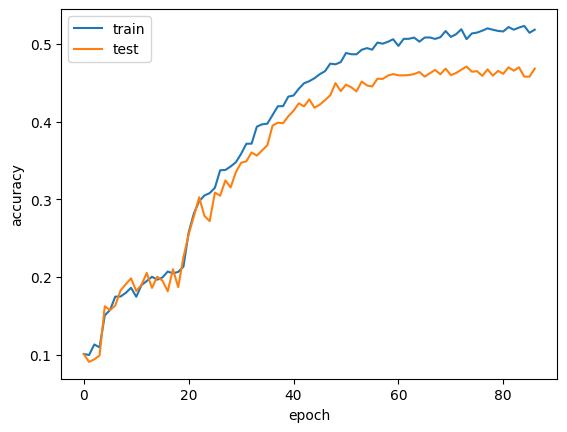

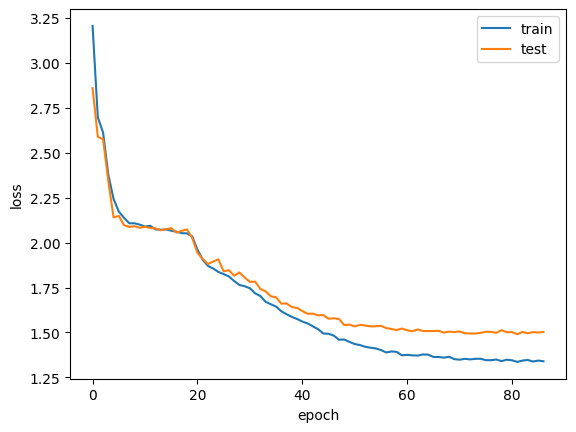

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.100857,0.100667,3.205845,2.859600
1,0.099571,0.090667,2.697604,2.588654
2,0.113143,0.094000,2.612714,2.575306
3,0.109429,0.099000,2.378491,2.343026
4,0.150571,0.162333,2.243438,2.140568
